In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler,  MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
import catboost as catb


"""import imblearn
print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import catboost as catb"""
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

Пути к файлам

In [3]:
train_dummies_prep = 'train_dummies_prepared.csv'
test_dummies_prep = 'test_dummies_prepared.csv'

train_prep = 'train_prepared.csv'
test_prep = 'test_prepared.csv'

train_dummies = 'train_dummies.csv'
test_dummies = 'test_dummies.csv'

Функции

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

Читаем файлы

In [5]:
train_df = pd.read_csv(train_dummies)
test_df = pd.read_csv(test_dummies)

Для предикта

In [6]:
pred_df = test_df.copy()

Разделение признаков

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5653 entries, 0 to 5652
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 5653 non-null   float64
 1   Tax Liens                     5653 non-null   float64
 2   Number of Open Accounts       5653 non-null   float64
 3   Years of Credit History       5653 non-null   float64
 4   Maximum Open Credit           5653 non-null   float64
 5   Number of Credit Problems     5653 non-null   float64
 6   Bankruptcies                  5653 non-null   float64
 7   Current Loan Amount           5653 non-null   float64
 8   Current Credit Balance        5653 non-null   float64
 9   Monthly Debt                  5653 non-null   float64
 10  Credit Default                5653 non-null   int64  
 11  Id                            5653 non-null   int64  
 12  Credit Score                  5653 non-null   float64
 13  Hom

In [8]:
NUM_FEATURES = ['Annual Income','Number of Open Accounts','Maximum Open Credit',
               'Current Loan Amount','Credit Score','Number of Credit Problems']

CAT_FEATURES = ['Years in current job_1','Years in current job_10','Years in current job_2',
               'Years in current job_3','Years in current job_4','Years in current job_5',
               'Years in current job_6','Years in current job_7','Years in current job_8',
                'Years in current job_9','Years in current job_0','Home Ownership_Have Mortgage',
               'Home Ownership_Home Mortgage','Home Ownership_Own Home','Home Ownership_Rent',
               'Purpose_business loan','Purpose_buy a car','Purpose_buy house','Purpose_debt consolidation',
               'Purpose_educational expenses','Purpose_home improvements','Purpose_major purchase','Purpose_medical bills',
               'Purpose_moving','Purpose_other','Purpose_small business','Purpose_take a trip',
               'Purpose_vacation','Purpose_wedding','Term_Long Term','Term_Short Term']

SELECTED_FEATURES = NUM_FEATURES + CAT_FEATURES

In [9]:
for col in CAT_FEATURES:
    train_df[col] = pd.Categorical(train_df[col])
    
train_df[CAT_FEATURES].dtypes

Years in current job_1          category
Years in current job_10         category
Years in current job_2          category
Years in current job_3          category
Years in current job_4          category
Years in current job_5          category
Years in current job_6          category
Years in current job_7          category
Years in current job_8          category
Years in current job_9          category
Years in current job_0          category
Home Ownership_Have Mortgage    category
Home Ownership_Home Mortgage    category
Home Ownership_Own Home         category
Home Ownership_Rent             category
Purpose_business loan           category
Purpose_buy a car               category
Purpose_buy house               category
Purpose_debt consolidation      category
Purpose_educational expenses    category
Purpose_home improvements       category
Purpose_major purchase          category
Purpose_medical bills           category
Purpose_moving                  category
Purpose_other   

Нормализация данных

In [10]:
scaler = StandardScaler()

train_scaled = train_df.copy()
train_scaled[NUM_FEATURES] = scaler.fit_transform(train_scaled[NUM_FEATURES])

df = train_scaled.copy()

In [11]:
df

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
0,-0.312570,0.0,0.975439,15.3,2.396593,-0.365580,0.0,-0.116650,394972.0,18373.0,...,0,0,0,0,0,0,0,0,1,0
1,-0.820958,0.0,-0.565197,22.5,-1.123407,1.606389,1.0,-0.986624,95855.0,11338.0,...,0,0,0,0,0,0,0,0,0,1
2,-0.887393,0.0,0.535257,13.6,-0.311969,1.606389,0.0,-0.959695,93309.0,7180.0,...,0,0,0,0,0,0,0,0,0,1
3,0.005188,0.0,0.315166,14.6,-0.376806,-0.365580,0.0,0.321669,165680.0,18692.0,...,0,0,0,1,0,0,0,0,1,0
4,-0.278958,0.0,0.535257,12.0,-0.500716,-0.365580,0.0,-0.201968,89015.0,19761.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,0.005188,0.0,-0.785288,8.2,-0.598795,-0.365580,0.0,0.037455,210938.0,5070.0,...,0,0,0,0,0,0,0,0,0,1
5649,-1.750175,0.0,-1.665651,8.5,-1.257948,-0.365580,0.0,-0.938366,73492.0,1900.0,...,0,0,0,1,0,0,0,0,0,1
5650,0.860257,0.0,-0.125015,26.5,0.710602,-0.365580,0.0,0.968484,456399.0,12783.0,...,0,0,0,0,0,0,0,0,1,0
5651,0.005188,0.0,2.295984,26.5,2.258833,-0.365580,0.0,2.006026,476064.0,37118.0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5653 entries, 0 to 5652
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 5653 non-null   float64 
 1   Tax Liens                     5653 non-null   float64 
 2   Number of Open Accounts       5653 non-null   float64 
 3   Years of Credit History       5653 non-null   float64 
 4   Maximum Open Credit           5653 non-null   float64 
 5   Number of Credit Problems     5653 non-null   float64 
 6   Bankruptcies                  5653 non-null   float64 
 7   Current Loan Amount           5653 non-null   float64 
 8   Current Credit Balance        5653 non-null   float64 
 9   Monthly Debt                  5653 non-null   float64 
 10  Credit Default                5653 non-null   int64   
 11  Id                            5653 non-null   int64   
 12  Credit Score                  5653 non-null   fl

Определим целевую переменную и удалим столбец Id

In [13]:
TARGET_NAME = 'Credit Default'

df.drop('Id', axis = 1, inplace=True)

Балансировка таргета + разбиение на трейн и тест по SMOTE

In [14]:
"""for colname in CAT_FEATURES:
    train_df[colname] = pd.Categorical(train_df[colname])

X_c = df[SELECTED_FEATURES]
y_c = df[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3)

print('до баллансировки :',np.sum(y_train))
sample = SMOTE(sampling_strategy='not majority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

print('после баллансировки :',np.sum(y_train))"""

"for colname in CAT_FEATURES:\n    train_df[colname] = pd.Categorical(train_df[colname])\n\nX_c = df[SELECTED_FEATURES]\ny_c = df[TARGET_NAME]\nX_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.3)\n\nprint('до баллансировки :',np.sum(y_train))\nsample = SMOTE(sampling_strategy='not majority')\nX_train, y_train = oversample.fit_resample(X_train, y_train)\n\nprint('после баллансировки :',np.sum(y_train))"

In [15]:
X = df[SELECTED_FEATURES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

БАЛАНСИРОВКА

In [16]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    2664
1    2586
Name: Credit Default, dtype: int64

In [17]:
X_c = df_balanced.drop(columns=TARGET_NAME)
y_c = df_balanced[TARGET_NAME]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, shuffle=True, test_size=0.30, random_state=21)

In [19]:
X_train.head()

,Annual Income,Number of Open Accounts,Maximum Open Credit,Current Loan Amount,Credit Score,Number of Credit Problems,Years in current job_1,Years in current job_10,Years in current job_2,Years in current job_3,...,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Term_Long Term,Term_Short Term
1735,1.707964,0.755348,-1.346444,-1.295234,0.218061,-0.365580,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4002,0.484784,-0.345106,-0.707581,0.254615,0.100235,1.606389,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3674,-0.611967,0.315166,-0.295947,-0.117717,1.003570,-0.365580,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3638,0.005188,-1.005379,-0.762535,-1.319896,0.335887,-0.365580,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2840,-1.332500,-0.565197,-0.859042,-0.767331,0.650091,-0.365580,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Логистическая регрессия

In [20]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.60      0.63      0.62      1826
           1       0.62      0.59      0.60      1849

    accuracy                           0.61      3675
   macro avg       0.61      0.61      0.61      3675
weighted avg       0.61      0.61      0.61      3675

TEST

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       838
           1       0.58      0.60      0.59       737

    accuracy                           0.61      1575
   macro avg       0.61      0.61      0.61      1575
weighted avg       0.61      0.61      0.61      1575

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               517  321
1               292  445


### CatBoost

In [21]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,cat_features=CAT_FEATURES)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1826
           1       0.84      0.84      0.84      1849

    accuracy                           0.84      3675
   macro avg       0.84      0.84      0.84      3675
weighted avg       0.84      0.84      0.84      3675

TEST

              precision    recall  f1-score   support

           0       0.72      0.67      0.70       838
           1       0.65      0.71      0.68       737

    accuracy                           0.69      1575
   macro avg       0.69      0.69      0.69      1575
weighted avg       0.69      0.69      0.69      1575

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               560  278
1               213  524


In [22]:
from catboost import Pool,cv

In [23]:
"""c_dataset = Pool(data=X_train,
                  label=y_train,
                cat_features=CAT_FEATURES)


params = {"iterations": 100,
          "max_depth":3,
          "eval_metric":"F1",
          "l2_leaf_reg":1.0,
          "loss_function": "Logloss",
          "colsample_bylevel":0.5,
          "verbose": False}
scores = cv(c_dataset,
            params,
            fold_count=3, 
            plot="True")"""

'c_dataset = Pool(data=X_train,\n                  label=y_train,\n                cat_features=CAT_FEATURES)\n\n\nparams = {"iterations": 100,\n          "max_depth":3,\n          "eval_metric":"F1",\n          "l2_leaf_reg":1.0,\n          "loss_function": "Logloss",\n          "colsample_bylevel":0.5,\n          "verbose": False}\nscores = cv(c_dataset,\n            params,\n            fold_count=3, \n            plot="True")'

In [24]:
"""catb_model_grid = catb.CatBoostClassifier(cat_features=CAT_FEATURES,iterations=100,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
          verbose=False)
grid = {'depth': [2,3,4, 5, 10],
        'l2_leaf_reg': [1,2,3]}
grid_search_result = catb_model_grid.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)"""

'catb_model_grid = catb.CatBoostClassifier(cat_features=CAT_FEATURES,iterations=100,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,\n          verbose=False)\ngrid = {\'depth\': [2,3,4, 5, 10],\n        \'l2_leaf_reg\': [1,2,3]}\ngrid_search_result = catb_model_grid.grid_search(grid, \n                                       X=X_train, \n                                       y=y_train, \n                                       plot=True)'

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif,chi2
from sklearn.feature_selection import SelectFromModel, SelectKBest

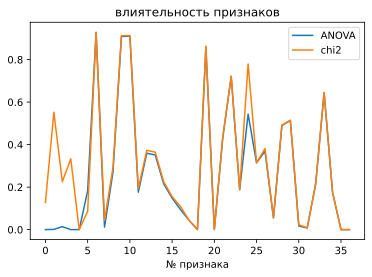

In [26]:
rez_c = chi2(np.abs(X_train[SELECTED_FEATURES]),y_train)
rez_f = f_classif(X_train[SELECTED_FEATURES],y_train)

plt.plot(rez_f[1], label= 'ANOVA')
plt.plot(rez_c[1],label='chi2')
plt.title('влиятельность признаков')
plt.xlabel('№ признака')
plt.legend()
plt.show()

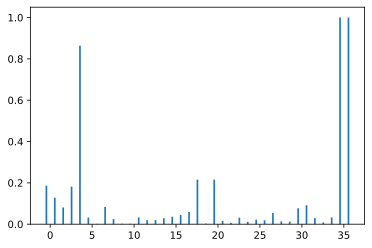

In [27]:
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(np.arange(X_train.shape[-1]) - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)')
plt.show()

In [28]:
ind_select =  np.where(selector.pvalues_>0.01)[0]
print(X_train.columns[ind_select])

Index(['Maximum Open Credit', 'Number of Credit Problems',
       'Years in current job_1', 'Years in current job_10',
       'Years in current job_2', 'Years in current job_3',
       'Years in current job_4', 'Years in current job_5',
       'Years in current job_6', 'Years in current job_7',
       'Years in current job_8', 'Years in current job_9',
       'Years in current job_0', 'Home Ownership_Have Mortgage',
       'Home Ownership_Own Home', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_take a trip', 'Purpose_vacation',
       'Purpose_wedding'],
      dtype='object')


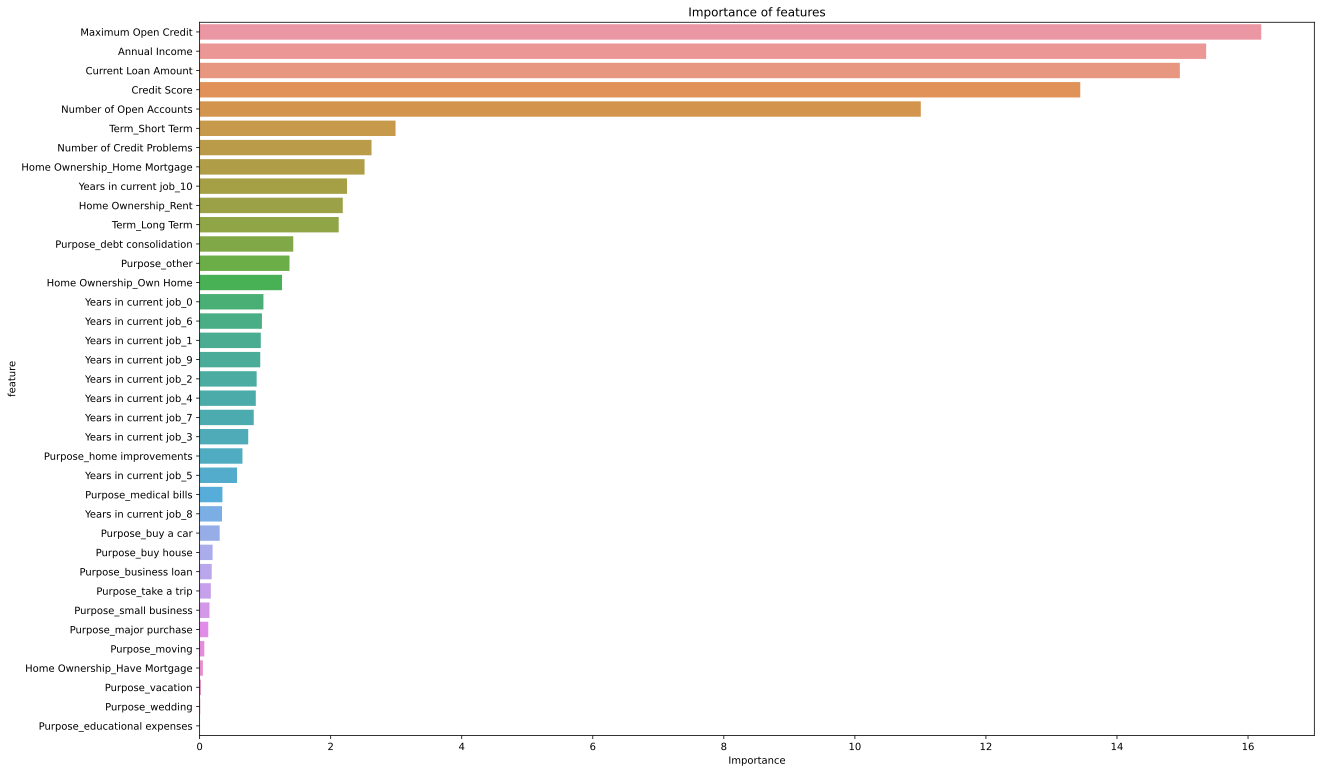

['Maximum Open Credit', 'Annual Income', 'Current Loan Amount', 'Credit Score', 'Number of Open Accounts', 'Term_Short Term', 'Number of Credit Problems', 'Home Ownership_Home Mortgage', 'Years in current job_10', 'Home Ownership_Rent', 'Term_Long Term', 'Purpose_debt consolidation', 'Purpose_other', 'Home Ownership_Own Home', 'Years in current job_0']


In [29]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)
print(important_features_top)

In [30]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_c[important_features_top], y_c, shuffle=True, test_size=0.30, random_state=21)

In [31]:
#NEW_CAT_FEATURES = ['Term_Short Term', 'Term_Long Term', 'Home Ownership_Home Mortgage', 'Years in current job_10', 'Home Ownership_Rent', 'Purpose_debt consolidation', 'Home Ownership_Own Home', 'Years in current job_2', 'Purpose_other']

In [32]:
NEW_CAT_FEATURES = ['Term_Short Term','Home Ownership_Home Mortgage', 'Years in current job_10', 'Home Ownership_Rent', 'Term_Long Term', 'Purpose_debt consolidation', 'Purpose_other', 'Home Ownership_Own Home', 'Years in current job_0']

In [33]:
BASELINE = X_train_new.columns.tolist()

In [34]:
train_dataset = Pool(data=X_train_new,
                  label=y_train,
                    cat_features=NEW_CAT_FEATURES)
val_dataset = Pool(data=X_test_new,
                    label=y_test,
                  cat_features=NEW_CAT_FEATURES)

In [35]:
catb_model = catb.CatBoostClassifier(cat_features=NEW_CAT_FEATURES,iterations=100,eval_metric="F1",loss_function="Logloss",colsample_bylevel=0.5,
         depth = 3, l2_leaf_reg = 2, verbose=False)
catb_model.fit(train_dataset)

In [36]:
print('ошибка cat = ',np.mean(np.abs(catb_model.predict(val_dataset)-y_test.astype(int)))*100,'%')
get_classification_report(y_train_new, catb_model.predict(train_dataset), y_test_new, catb_model.predict(val_dataset))

ошибка cat =  37.77777777777778 %
TRAIN

              precision    recall  f1-score   support

           0       0.61      0.66      0.63      1826
           1       0.63      0.58      0.60      1849

    accuracy                           0.62      3675
   macro avg       0.62      0.62      0.62      3675
weighted avg       0.62      0.62      0.62      3675

TEST

              precision    recall  f1-score   support

           0       0.65      0.64      0.64       838
           1       0.60      0.60      0.60       737

    accuracy                           0.62      1575
   macro avg       0.62      0.62      0.62      1575
weighted avg       0.62      0.62      0.62      1575

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               539  299
1               296  441


## Тестовые данные

In [37]:
test_df.shape

(2500, 43)

In [38]:
TEST_NUM_FEATURES = ['Annual Income','Number of Open Accounts','Maximum Open Credit',
               'Current Loan Amount','Credit Score','Number of Credit Problems']

TEST_CAT_FEATURES = ['Years in current job_1','Years in current job_10','Years in current job_2',
               'Years in current job_3','Years in current job_4','Years in current job_5',
               'Years in current job_6','Years in current job_7','Years in current job_8',
                'Years in current job_9','Years in current job_0','Home Ownership_Have Mortgage',
               'Home Ownership_Home Mortgage','Home Ownership_Own Home','Home Ownership_Rent',
               'Purpose_business loan','Purpose_buy a car','Purpose_buy house','Purpose_debt consolidation',
               'Purpose_educational expenses','Purpose_home improvements','Purpose_major purchase','Purpose_medical bills',
               'Purpose_moving','Purpose_other','Purpose_small business','Purpose_take a trip',
               'Purpose_vacation','Purpose_wedding','Term_Long Term','Term_Short Term']

TEST_SELECTED_FEATURES = NUM_FEATURES + CAT_FEATURES

In [39]:
for col in TEST_CAT_FEATURES:
    test_df[col] = pd.Categorical(test_df[col])
    
test_df[TEST_CAT_FEATURES].dtypes

Years in current job_1          category
Years in current job_10         category
Years in current job_2          category
Years in current job_3          category
Years in current job_4          category
Years in current job_5          category
Years in current job_6          category
Years in current job_7          category
Years in current job_8          category
Years in current job_9          category
Years in current job_0          category
Home Ownership_Have Mortgage    category
Home Ownership_Home Mortgage    category
Home Ownership_Own Home         category
Home Ownership_Rent             category
Purpose_business loan           category
Purpose_buy a car               category
Purpose_buy house               category
Purpose_debt consolidation      category
Purpose_educational expenses    category
Purpose_home improvements       category
Purpose_major purchase          category
Purpose_medical bills           category
Purpose_moving                  category
Purpose_other   

In [40]:
scaler = StandardScaler()

test_scaled = test_df.copy()
test_scaled[TEST_NUM_FEATURES] = scaler.fit_transform(test_scaled[TEST_NUM_FEATURES])

df_test = test_scaled.copy()

In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 2500 non-null   float64 
 1   Tax Liens                     2500 non-null   float64 
 2   Number of Open Accounts       2500 non-null   float64 
 3   Years of Credit History       2500 non-null   float64 
 4   Maximum Open Credit           2500 non-null   float64 
 5   Number of Credit Problems     2500 non-null   float64 
 6   Bankruptcies                  2500 non-null   float64 
 7   Current Loan Amount           2500 non-null   float64 
 8   Current Credit Balance        2500 non-null   float64 
 9   Monthly Debt                  2500 non-null   float64 
 10  Id                            2500 non-null   int64   
 11  Credit Score                  2500 non-null   float64 
 12  Home Ownership_Have Mortgage  2500 non-null   ca

In [42]:
df_test.drop('Id', axis = 1, inplace=True)

In [43]:
df_test[BASELINE]

,Maximum Open Credit,Annual Income,Current Loan Amount,Credit Score,Number of Open Accounts,Term_Short Term,Number of Credit Problems,Home Ownership_Home Mortgage,Years in current job_10,Home Ownership_Rent,Term_Long Term,Purpose_debt consolidation,Purpose_other,Home Ownership_Own Home,Years in current job_0
0,-0.632021,-0.187339,-0.634301,0.238120,-0.450224,1,-0.289398,0,0,1,0,1,0,0,0
1,-0.870188,-1.571980,-0.910305,-0.886681,-1.068551,1,-0.289398,0,0,1,0,0,0,0,0
2,-0.655644,-0.230068,-0.510655,0.197949,-0.244115,1,-0.289398,1,0,0,0,1,0,0,0
3,-0.292378,-0.131290,-0.454242,0.720178,0.992538,1,-0.289398,1,1,0,0,1,0,0,0
4,0.791452,1.502028,1.382853,-0.605480,-0.038006,0,-0.289398,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,-0.143941,-0.423166,0.666439,0.961207,0.580320,1,1.497011,1,1,0,0,1,0,0,0
2496,1.557102,-0.187339,0.369226,0.238120,0.786429,1,-0.289398,1,0,0,0,1,0,0,0
2497,1.511857,-0.201988,0.244570,-1.047367,7.588024,1,-0.289398,1,0,0,0,1,0,0,0
2498,0.414056,-0.855360,-0.321795,0.921035,0.580320,1,-0.289398,0,1,1,0,1,0,0,0


In [44]:
prediction = catb_model.predict(df_test[BASELINE])

In [45]:
pred_df[TARGET_NAME] = prediction
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Tax Liens                     2500 non-null   float64
 2   Number of Open Accounts       2500 non-null   float64
 3   Years of Credit History       2500 non-null   float64
 4   Maximum Open Credit           2500 non-null   float64
 5   Number of Credit Problems     2500 non-null   float64
 6   Bankruptcies                  2500 non-null   float64
 7   Current Loan Amount           2500 non-null   float64
 8   Current Credit Balance        2500 non-null   float64
 9   Monthly Debt                  2500 non-null   float64
 10  Id                            2500 non-null   int64  
 11  Credit Score                  2500 non-null   float64
 12  Home Ownership_Have Mortgage  2500 non-null   int64  
 13  Hom

In [46]:
pred_df[['Id', TARGET_NAME]].to_csv('Kochetkov_MD_predictions_final.csv', index=False)

In [47]:
df_2 = pd.read_csv('Kochetkov_MD_predictions.csv')
df_3 = pd.read_csv('Kochetkov_MD_predictions_final.csv')